In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import flg_yolo
import flg_diagnostics
import pandas as pd

fast_mode = False
if fls.is_submission:
    fast_mode = False

MainProcess


In [2]:
# Prepare datasets
fls.download_kaggle_dataset('jeroencottaar/byu-many-models/', fls.result_dir + '/many_full_res/')

In [6]:
data = fls.dill_load(fls.result_dir + '/many_full_res/Baseline_1004_dbb9ae99_887 _f.pickle')
data.inferred_test_data = data.inferred_test_data[25:35]
data.test_data = data.test_data[25:35]
print(fls.score_competition_metric(data.inferred_test_data, data.test_data))
data.trained_model.data_after_step2 = data.inferred_test_data
#for d in data.inferred_test_data:
#    data.trained_model.data_after_step2.append(d)
#print(fls.score_competition_metric(data.inferred_test_data, data.test_data))

(0.5714285714285714, 0.8, 0.7407407407407407)


In [7]:
ref_data = data.test_data
#data.trained_model.step3Output.threshold = -1.
data.trained_model.ratio_of_motors_allowed = 1.#np.sum([len(d.labels)>0 for d in data.test_data])/len(data.test_data)

model2 = flg_model.TestTimeAugmentation(model_internal=data.trained_model)
model2.model_internal.data_after_step2 = []
#model2.voxel_spacing_scale_vals = [1.]
model2.state = 1
model2.ratio_of_motors_allowed = data.trained_model.ratio_of_motors_allowed

model2 = data.trained_model

inferred_data = model2.infer(data.test_data)
print(fls.score_competition_metric(inferred_data, data.test_data))
# inferred_data = data.inferred_test_data

(0.5, 1.0, 0.8333333333333334)


(array([        245,         117,           0,         264,          58,         290,          51,         171,           0,          91]),
 array([       5.12,      6.5813,      8.0426,      9.5039,      10.965,      12.427,      13.888,      15.349,       16.81,      18.272,      19.733]),
 <BarContainer object of 10 artists>)

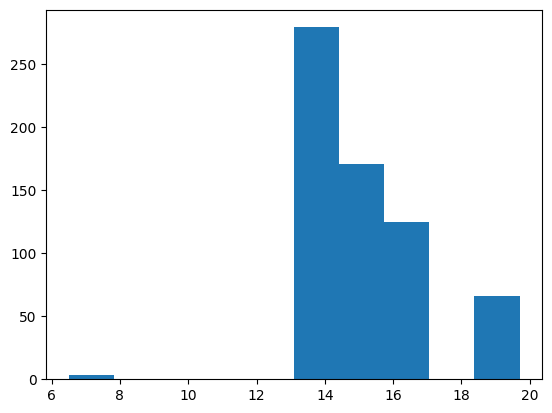

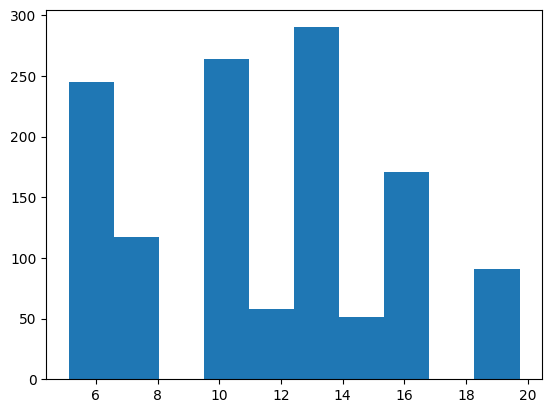

In [8]:
plt.figure()
plt.hist([d.voxel_spacing for d in fls.load_all_train_data()])
plt.figure()
plt.hist([d.voxel_spacing for d in fls.load_all_extra_data()])


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


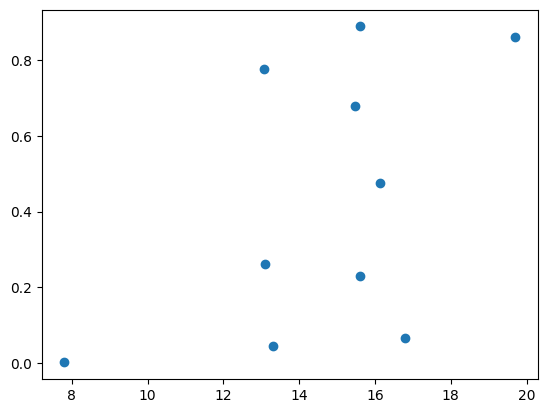

In [9]:
print([len(r.labels) for r in data.test_data])
print([len(d.labels) for d in data.inferred_test_data])
print([len(d.labels) for d in inferred_data])
def get_conf(dd):
    if len(dd.labels_unfiltered)==0:
        return 0
    else:
        return np.max(dd.labels_unfiltered['confidence'])
plt.scatter([d.voxel_spacing for d in inferred_data], [get_conf(d) for d in inferred_data])

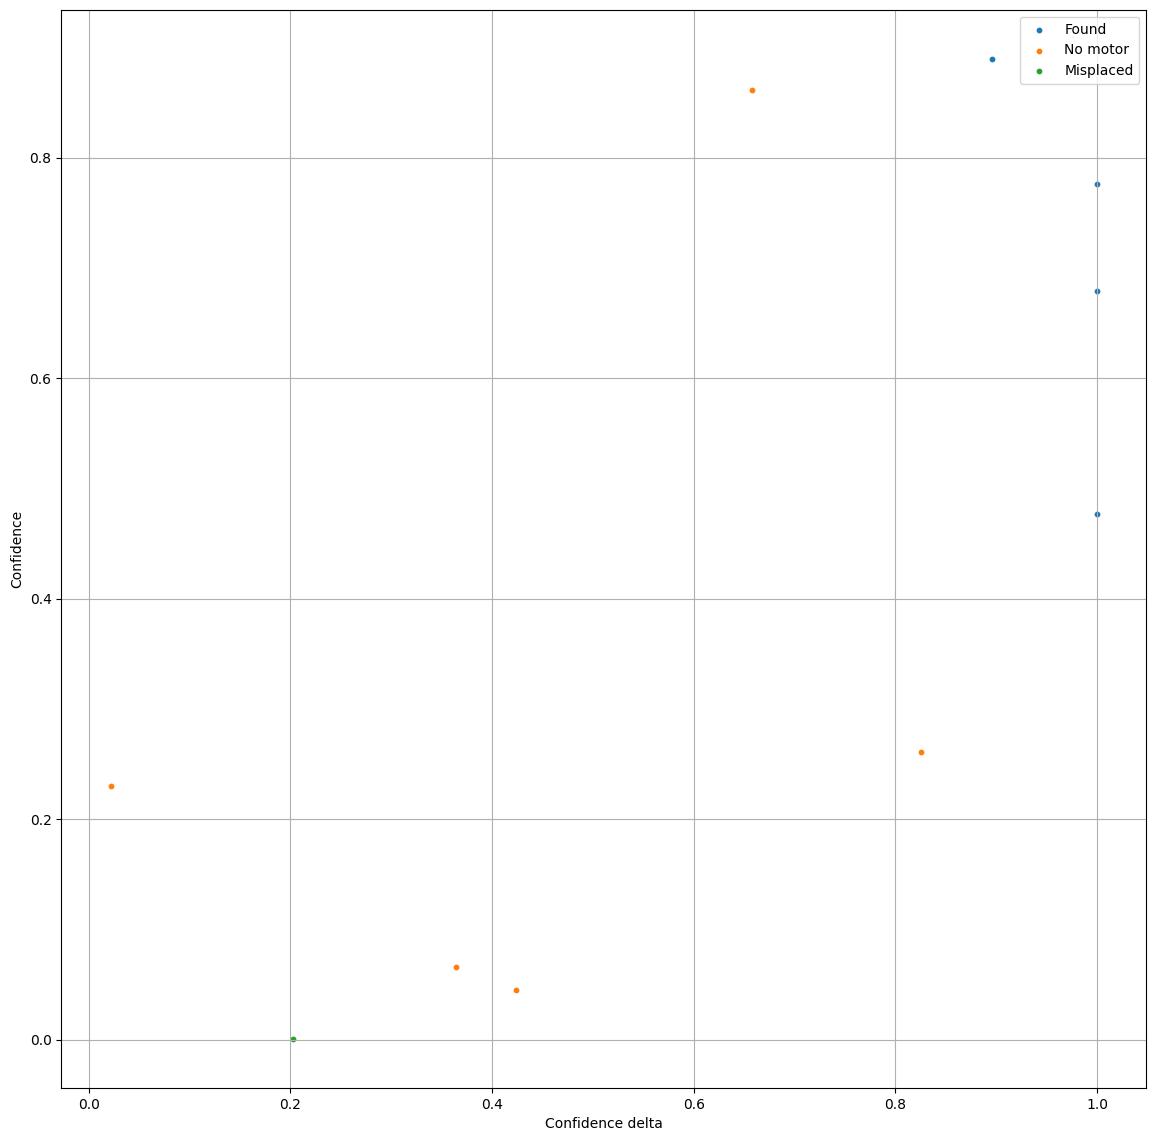

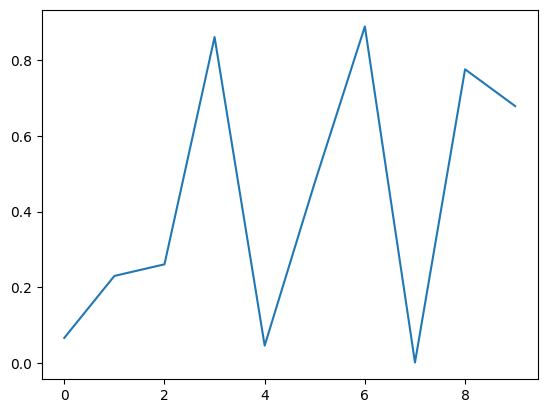

In [10]:
res = []
inferred_data_check = copy.deepcopy(inferred_data)
for d in inferred_data_check:
    #d.labels_unfiltered = d.labels.reset_index()
    if len(d.labels_unfiltered)==0:
        print(d.name)
        assert(len(d.labels)==0)
        di = {'z':0, 'y':0, 'x':0, 'confidence':0}
        d.labels_unfiltered = pd.DataFrame([di])
fls.mark_tf_pn(inferred_data_check, data.test_data)
res_list = []
for c,d,t in zip(inferred_data_check, inferred_data, data.test_data):
    res = dict()
    res['confidence'] = np.max(c.labels_unfiltered['confidence'])#.at[0,'confidence']
    if len(d.labels_unfiltered)>1:
        vals = np.sort(d.labels_unfiltered['confidence'])
        #assert vals[-1] == res['confidence']
        res['confidence_delta'] = (vals[-1]-vals[-2])/vals[-1]
    else:
        res['confidence_delta'] = 1#res['confidence']
    if c.labels_unfiltered.at[0,'tf_pn']==0:
        res['category'] = 'found'         
    elif len(t.labels)>0:
        res['category'] = 'misplaced'
    else:
        res['category'] = 'no motor'
    #if c.name[:3]=='tom':
    res_list.append(res)
result = pd.DataFrame(res_list)

plt.figure(figsize=(14,14))
plt.grid(True)
plt.xlabel('Confidence delta')
plt.ylabel('Confidence')
to_plot = (result['category']=='found')
plt.scatter(result['confidence_delta'][to_plot], result['confidence'][to_plot], s=10)
to_plot = (result['category']=='no motor')
plt.scatter(result['confidence_delta'][to_plot], result['confidence'][to_plot], s=10)
to_plot = (result['category']=='misplaced')
plt.scatter(result['confidence_delta'][to_plot], result['confidence'][to_plot], s=10)
#plt.legend(['Found', 'No motor'])
plt.legend(['Found', 'No motor', 'Misplaced'])
plt.figure()
plt.plot(result['confidence'])

True positives: 5 out of 5


C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


False negatives - seen but subthreshold or overshadowed: 0 out of 5


ValueError: need at least one array to stack

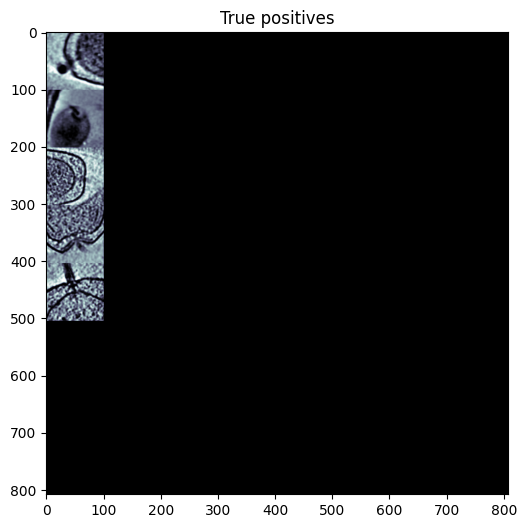

In [11]:
import flg_preprocess
importlib.reload(flg_diagnostics)
importlib.reload(flg_numerics)
importlib.reload(flg_preprocess)
flg_diagnostics.show_tf_pn(inferred_data, ref_data)